## Part 1: Introduction

### 1.1. Import libraries

In [28]:
import pandas as pd
import numpy as np 

# Sklearn modules for data splitting, preprocessing, model building and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# Models to be used for classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# Visualization
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
from sklearn.calibration import calibration_curve

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, brier_score_loss


### 1.2. Load Dataset

In [29]:
#df = pd.read_csv("../data/raw/train.csv") # stien til datafilen når det er i IdaData.ipynb
df = pd.read_csv("../../data/raw/train.csv") # stien til datafilen når det er i data.ipynb

## Part 2: Data Preparation

### 2.1. Data Description and Inspection

In [30]:
# Print the shape of the dataframe
df.shape

(1048, 65)

In [31]:
# Print the first few rows of the dataframe
df.head()

,is_dater_male,dater_age,dated_age,age_difference,dater_race,dated_race,are_same_race,same_race_importance_for_dater,same_religion_importance_for_dater,attractiveness_importance_for_dated,...,interests_correlation,expected_satisfaction_of_dater,expected_number_of_likes_of_dater_from_20_people,expected_number_of_dates_for_dater,dater_liked_dated,probability_dated_wants_to_date,already_met_before,dater_wants_to_date,dated_wants_to_date,is_match
0,False,21,27,6,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,35.0,...,0.14,3.0,2,4,7.0,6.0,True,True,False,0
1,False,21,22,1,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,60.0,...,0.54,3.0,2,4,7.0,5.0,True,True,False,0
2,False,21,23,2,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,30.0,...,0.61,3.0,2,4,7.0,6.0,True,True,True,1
3,False,21,24,3,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',False,2.0,4.0,30.0,...,0.21,3.0,2,4,6.0,6.0,True,True,True,1
4,False,21,25,4,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,50.0,...,0.25,3.0,2,4,6.0,5.0,True,False,True,0


In [32]:
# Print the data types of each column
df.dtypes

is_dater_male                         bool
dater_age                            int64
dated_age                            int64
age_difference                       int64
dater_race                          object
                                    ...   
probability_dated_wants_to_date    float64
already_met_before                    bool
dater_wants_to_date                   bool
dated_wants_to_date                   bool
is_match                             int64
Length: 65, dtype: object

### 2.2. Data Preprocessing and Cleaning 

In [33]:
# Remove rows with missing values
df = df.dropna(subset=["is_match"])

In [34]:
# Change the column names to don't use underscores and to use upper first letters
df.columns = [col.replace('_', ' ').title() for col in df.columns]

In [35]:
# print all the column names
print(df.columns.tolist())

['Is Dater Male', 'Dater Age', 'Dated Age', 'Age Difference', 'Dater Race', 'Dated Race', 'Are Same Race', 'Same Race Importance For Dater', 'Same Religion Importance For Dater', 'Attractiveness Importance For Dated', 'Sincerity Importance For Dated', 'Intelligence Importance For Dated', 'Humor Importance For Dated', 'Ambition Importance For Dated', 'Shared Interests Importance For Dated', 'Attractiveness Score Of Dater From Dated', 'Sincerity Score Of Dater From Dated', 'Intelligence Score Of Dater From Dated', 'Humor Score Of Dater From Dated', 'Ambition Score Of Dater From Dated', 'Shared Interests Score Of Dater From Dated', 'Attractiveness Importance For Dater', 'Sincerity Importance For Dater', 'Intelligence Importance For Dater', 'Humor Importance For Dater', 'Ambition Importance For Dater', 'Shared Interests Importance For Dater', 'Self Reported Attractiveness Of Dater', 'Self Reported Sincerity Of Dater', 'Self Reported Intelligence Of Dater', 'Self Reported Humor Of Dater', '

In [36]:
# Store all column names before making changes
cols_before = set(df.columns)

# Drop unwanted columns (gender, religion, etc.)
df = df.drop(
    columns=[
        "Dated Wants To Date",
        "Dater Wants To Date",
        "Same Race Importance For Dater",
        "Same Religion Importance For Dater"
    ],
    errors="ignore"  # ignore errors if any columns are missing
)

# Drop all columns containing the word 'Race'
race_cols = [col for col in df.columns if "Race" in col]
df = df.drop(columns=race_cols, errors="ignore")

# Compare column sets before and after to see which columns were removed for verification
cols_after = set(df.columns)
removed_cols = cols_before - cols_after

# Print removed columns
print("Removed columns:", removed_cols)

Removed columns: {'Dater Wants To Date', 'Dated Wants To Date', 'Dated Race', 'Same Race Importance For Dater', 'Are Same Race', 'Dater Race', 'Same Religion Importance For Dater'}


In [37]:
# Convert categorical variables to numerical dummy variables using one-hot encoding
df = pd.get_dummies(df, drop_first=True)
df.head()

,Is Dater Male,Dater Age,Dated Age,Age Difference,Attractiveness Importance For Dated,Sincerity Importance For Dated,Intelligence Importance For Dated,Humor Importance For Dated,Ambition Importance For Dated,Shared Interests Importance For Dated,...,Dater Interest In Shopping,Dater Interest In Yoga,Interests Correlation,Expected Satisfaction Of Dater,Expected Number Of Likes Of Dater From 20 People,Expected Number Of Dates For Dater,Dater Liked Dated,Probability Dated Wants To Date,Already Met Before,Is Match
0,False,21,27,6,35.0,20.0,20.0,20.0,0.0,5.0,...,8.0,1.0,0.14,3.0,2,4,7.0,6.0,True,0
1,False,21,22,1,60.0,0.0,0.0,40.0,0.0,0.0,...,8.0,1.0,0.54,3.0,2,4,7.0,5.0,True,0
2,False,21,23,2,30.0,5.0,15.0,40.0,5.0,5.0,...,8.0,1.0,0.61,3.0,2,4,7.0,6.0,True,1
3,False,21,24,3,30.0,10.0,20.0,10.0,10.0,20.0,...,8.0,1.0,0.21,3.0,2,4,6.0,6.0,True,1
4,False,21,25,4,50.0,0.0,30.0,10.0,0.0,10.0,...,8.0,1.0,0.25,3.0,2,4,6.0,5.0,True,0


In [38]:
# Print the shape of the dataframe after cleaning
df.shape

(1048, 58)

In [39]:
# Get summary statistics of the dataframe
df.describe()

,Dater Age,Dated Age,Age Difference,Attractiveness Importance For Dated,Sincerity Importance For Dated,Intelligence Importance For Dated,Humor Importance For Dated,Ambition Importance For Dated,Shared Interests Importance For Dated,Attractiveness Score Of Dater From Dated,...,Dater Interest In Music,Dater Interest In Shopping,Dater Interest In Yoga,Interests Correlation,Expected Satisfaction Of Dater,Expected Number Of Likes Of Dater From 20 People,Expected Number Of Dates For Dater,Dater Liked Dated,Probability Dated Wants To Date,Is Match
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,...,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,25.005725,24.818702,3.032443,23.728235,16.971021,22.255887,17.325029,9.725792,10.333626,6.211355,...,7.710878,5.511450,4.133588,0.154990,5.378817,5.760496,2.844466,6.218034,4.978053,0.177481
std,3.270365,3.180581,2.427732,12.660571,7.450629,7.352106,6.666005,7.073420,6.763784,1.964935,...,1.899931,2.597821,2.696578,0.335816,1.630245,4.954703,2.370152,1.858517,2.269876,0.382258
min,18.000000,18.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,-0.630000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,22.000000,1.000000,15.000000,10.000000,20.000000,10.832500,5.000000,5.000000,5.000000,...,7.000000,4.000000,2.000000,-0.110000,5.000000,2.000000,1.000000,5.000000,3.000000,0.000000
50%,25.000000,25.000000,2.000000,20.000000,18.000000,20.000000,18.180000,10.000000,10.000000,6.000000,...,8.000000,5.000000,3.000000,0.150000,5.000000,4.000000,2.000000,6.000000,5.000000,0.000000
75%,27.000000,27.000000,4.000000,30.000000,20.000000,25.000000,20.000000,15.000000,15.000000,8.000000,...,9.000000,8.000000,7.000000,0.420000,7.000000,8.000000,4.000000,7.000000,7.000000,0.000000
max,35.000000,35.000000,14.000000,100.000000,40.000000,50.000000,40.000000,53.000000,30.000000,10.000000,...,10.000000,10.000000,10.000000,0.900000,9.000000,20.000000,10.000000,10.000000,10.000000,1.000000


### 2.3. Split Features and Target Variable

In [40]:
# Split the data into features and target variable
# "Is Match" is the target variable and is binary (0 or 1) indicating if there was a match or not
X = df.drop("Is Match", axis=1)
y = df["Is Match"]

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20, # the dataset is small, so use 20% for testing
    stratify=y,
    random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Define K-fold cross-validation on the training data
# This 'cv' object will be used later when training/evaluating models
# CV means cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

Train: 838, Test: 210


## Part 3: Modelling

### 3.1. Baseline Model

=== DummyClassifier (Most Frequent) ===
Accuracy:  0.824
Precision: 0.000
Recall:    0.000
F1-score:  0.000

Classification report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       173
           1       0.00      0.00      0.00        37

    accuracy                           0.82       210
   macro avg       0.41      0.50      0.45       210
weighted avg       0.68      0.82      0.74       210

Confusion matrix:
[[173   0]
 [ 37   0]]


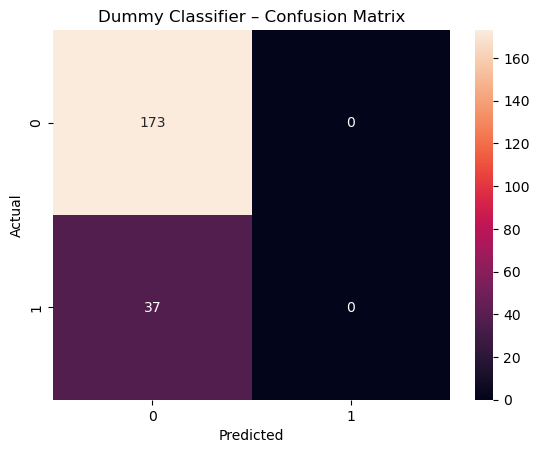

In [41]:
# Baseline model: always predicts the most frequent class in y_train
dummy_clf = DummyClassifier(strategy='most_frequent')

# Train on the *original* training data
dummy_clf.fit(X_train, y_train)

# Predict on test data
y_pred_dummy = dummy_clf.predict(X_test)

# Metrics
acc_dummy = accuracy_score(y_test, y_pred_dummy)
pre_dummy = precision_score(y_test, y_pred_dummy, zero_division=0)
rec_dummy = recall_score(y_test, y_pred_dummy, zero_division=0)
f1_dummy = f1_score(y_test, y_pred_dummy, zero_division=0)

print("=== DummyClassifier (Most Frequent) ===")
print(f"Accuracy:  {acc_dummy:.3f}")
print(f"Precision: {pre_dummy:.3f}")
print(f"Recall:    {rec_dummy:.3f}")
print(f"F1-score:  {f1_dummy:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

# Confusion matrix
cm_dummy = confusion_matrix(y_test, y_pred_dummy)
print("Confusion matrix:")
print(cm_dummy)

sns.heatmap(cm_dummy, annot=True, fmt="d")
plt.title("Dummy Classifier – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 3.2. Logistic Regression

#### 3.2.1. Logistic Regression with Cross-Validation

In [42]:
# Build a pipeline: scaling + model
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=1000))
])

# Run cross-validation on the training data with the different scoring metrics
# Accuracy
lr_acc_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

# F1-score
lr_f1_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="f1"
)

# Recall
lr_rec_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="recall"
)

# Precision
lr_pre_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="precision"
)

# Print the cross-validation scores
print("Logistic Regression CV Accuracy Scores:", lr_acc_scores)
#print("Logistic Regression mean CV Accuracy Score:", lr_acc_scores.mean())

print("Logistic Regression CV F1 Scores:", lr_f1_scores)
#print("Logistic Regression mean CV F1 Score:", lr_f1_scores.mean())

print("Logistic Regression CV Recall Scores:", lr_rec_scores)
#print("Logistic Regression mean CV Recall Score:", lr_rec_scores.mean())

print("Logistic Regression CV Precision Scores:", lr_pre_scores)
#print("Logistic Regression mean CV Precision Score:", lr_pre_scores.mean())

# Build results table
lr_results_before = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "Recall", "Precision"],
    "Mean CV Score for LR": [
        lr_acc_scores.mean(),
        lr_f1_scores.mean(),
        lr_rec_scores.mean(),
        lr_pre_scores.mean()
    ]
})

# Round and sort for readability
lr_results_before = lr_results_before.round(4).sort_values(by="Mean CV Score for LR", ascending=False).reset_index(drop=True)

lr_results_before

Logistic Regression CV Accuracy Scores: [0.85119048 0.8452381  0.83928571 0.85628743 0.86227545]
Logistic Regression CV F1 Scores: [0.48979592 0.45833333 0.55737705 0.52       0.58181818]
Logistic Regression CV Recall Scores: [0.4        0.36666667 0.56666667 0.44827586 0.53333333]
Logistic Regression CV Precision Scores: [0.63157895 0.61111111 0.5483871  0.61904762 0.64      ]


,Metric,Mean CV Score for LR
0,Accuracy,0.8509
1,Precision,0.6100
2,F1-score,0.5215
3,Recall,0.4630


#### 3.2.2. Fine-Tune Logistic Regression with GridSearchCV

In [43]:
# Hyperparameter grid
lr_param_grid = {
    "log_reg__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "log_reg__penalty": ["l1", "l2"],
    "log_reg__solver": ["liblinear", "saga"],
    "log_reg__class_weight": [None, "balanced"],
}

# Evaluate several metrics and choose which one to optimize (refit)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall", 
    "precision": "precision"
}

# Set up GridSearchCV with multiple scoring metrics
lr_grid = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=cv,
    scoring=scoring,
    refit="f1",                
    return_train_score=True,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
lr_grid.fit(X_train, y_train)

# Report best parameters and best score for the refit metric (F1)
print("Best params:", lr_grid.best_params_)
print("Best CV F1 (refit metric):", lr_grid.best_score_)


# Also report best scores for the other metrics for the selected best_index_
best_i = lr_grid.best_index_

# Get the cross-validation results
lr_cvres = lr_grid.cv_results_

# Get the metrics at the best F1 index
lr_acc_after = lr_cvres["mean_test_accuracy"][best_i]
lr_rec_after = lr_cvres["mean_test_recall"][best_i]
lr_f1_after = lr_cvres["mean_test_f1"][best_i]
lr_pre_after = lr_cvres["mean_test_precision"][best_i]

# Create a DataFrame to display the results
lr_results_after = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "F1-score", "Precision"],
    "CV Score for LR (After Tuning)": [
        lr_acc_after,
        lr_rec_after,
        lr_f1_after,
        lr_pre_after
    ]
})

# Round for cleaner display
lr_results_after = lr_results_after.round(4).sort_values(by="CV Score for LR (After Tuning)", ascending=False).reset_index(drop=True)

lr_results_after

Best params: {'log_reg__C': 0.1, 'log_reg__class_weight': 'balanced', 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga'}
Best CV F1 (refit metric): 0.5516535719979048


,Metric,CV Score for LR (After Tuning)
0,Accuracy,0.7792
1,Recall,0.7582
2,F1-score,0.5517
3,Precision,0.4370


### 3.3. Decision Tree

#### 3.3.1. Decision Tree with Cross-Validation

In [44]:
# Decision Tree without scaling (tree models are scale-invariant)
dt_model = DecisionTreeClassifier(
    random_state=42
)

# Run cross-validation on the training data for performance evaluation
# Accuracy
dt_acc_scores = cross_val_score(
    dt_model,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

# F1-score
dt_f1_scores = cross_val_score(
    dt_model,
    X_train,
    y_train,
    cv=cv,
    scoring="f1"
)

# Recall
dt_rec_scores = cross_val_score(
    dt_model,
    X_train,
    y_train,
    cv=cv,
    scoring="recall"
)

# Precision
dt_pre_scores = cross_val_score(
    dt_model,
    X_train,
    y_train,
    cv=cv,
    scoring="precision"
)

# Print Decision Tree CV scores
print("Decision Tree CV Accuracy scores:", dt_acc_scores)
#print("Decision Tree mean Accuracy:", dt_acc_scores.mean())

print("Decision Tree CV F1 scores:", dt_f1_scores)
#print("Decision Tree mean F1:", dt_f1_scores.mean())

print("Decision Tree CV Recall scores:", dt_rec_scores)
#print("Decision Tree mean Recall:", dt_rec_scores.mean())

print("Decision Tree CV Precision scores:", dt_pre_scores)
#print("Decision Tree mean Precision:", dt_pre_scores.mean())

# Build results table
dt_results_before = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "Recall", "Precision"],
    "Mean CV Score for DT": [
        dt_acc_scores.mean(),
        dt_f1_scores.mean(),
        dt_rec_scores.mean(),
        dt_pre_scores.mean()
    ]
})

# Round and sort for readability
dt_results_before = dt_results_before.round(4).sort_values(by="Mean CV Score for DT", ascending=False).reset_index(drop=True)

dt_results_before

Decision Tree CV Accuracy scores: [0.83928571 0.83928571 0.79166667 0.78443114 0.76047904]
Decision Tree CV F1 scores: [0.54237288 0.55737705 0.38596491 0.41935484 0.41176471]
Decision Tree CV Recall scores: [0.53333333 0.56666667 0.36666667 0.44827586 0.46666667]
Decision Tree CV Precision scores: [0.55172414 0.5483871  0.40740741 0.39393939 0.36842105]


,Metric,Mean CV Score for DT
0,Accuracy,0.8030
1,Recall,0.4763
2,F1-score,0.4634
3,Precision,0.4540


#### 3.3.2. Fine-Tune Decision Tree with GridSearchCV


In [45]:
# Hyperparameter grid
param_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# Evaluate several metrics and choose which one to optimize (refit)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall", 
    "precision": "precision"
}

# GridSearch
dt_grid = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",
    cv=cv,
    n_jobs=-1
)

# Fit
dt_grid.fit(X_train, y_train)

# Report best parameters and best score for the refit metric (F1)
print("Best params:", dt_grid.best_params_)
print("Best CV F1 (refit metric):", dt_grid.best_score_)

# Also report best scores for the other metrics for the selected best_index_
best_i = dt_grid.best_index_

# Get the cross-validation results
cvres = dt_grid.cv_results_

# Get the metrics at the best F1 index
dt_acc_after = cvres["mean_test_accuracy"][best_i]
dt_rec_after = cvres["mean_test_recall"][best_i]
dt_f1_after = cvres["mean_test_f1"][best_i]
dt_pre_after = cvres["mean_test_precision"][best_i]

# Create a DataFrame to display the results
dt_results_after = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "F1-score", "Precision"],
    "CV Score for DT (After Tuning)": [
        dt_acc_after,
        dt_rec_after,
        dt_f1_after,
        dt_pre_after
    ]
})

# Round for cleaner display
dt_results_after = dt_results_after.round(4).sort_values(by="CV Score for DT (After Tuning)", ascending=False).reset_index(drop=True)

dt_results_after


Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV F1 (refit metric): 0.48506238859180045


,Metric,CV Score for DT (After Tuning)
0,Accuracy,0.8413
1,Precision,0.5850
2,F1-score,0.4851
3,Recall,0.4163


#### 3.3.3. Visualize the Decision Tree

##### 3.3.3.1. Plot the Tuned Tree

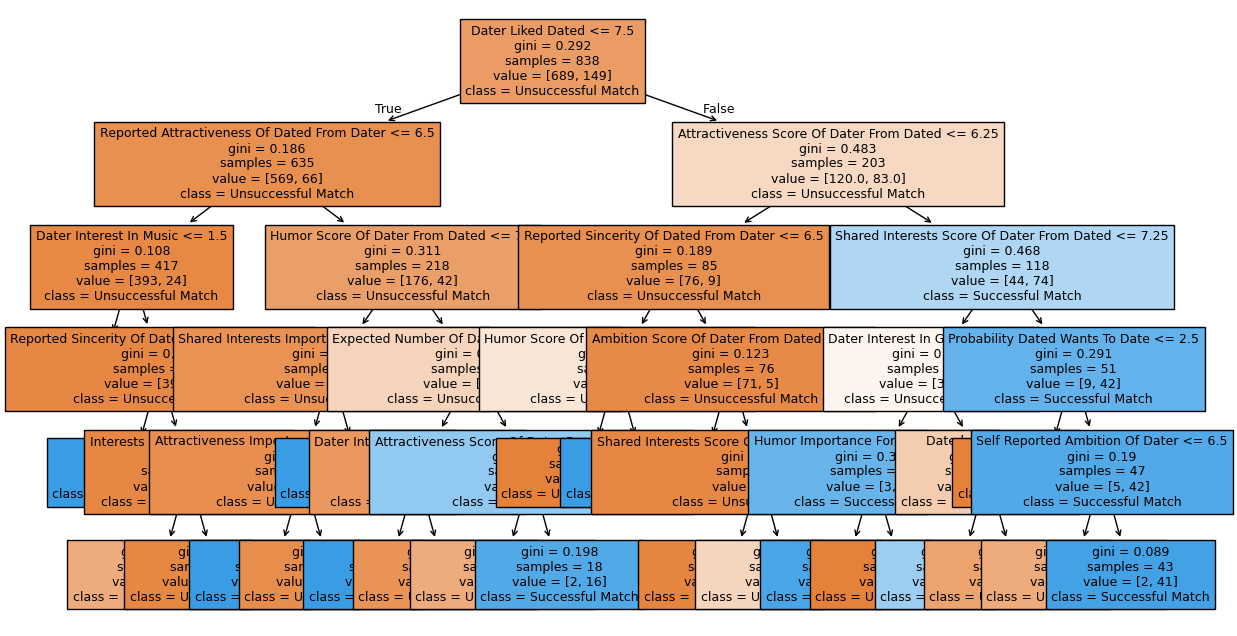

In [46]:
# Visualize the Decision Tree
best_dt = dt_grid.best_estimator_

plt.figure(figsize=(14, 8))

# Plot the tree
tree.plot_tree(
    best_dt,
    feature_names=list(X_train.columns),
    class_names=["Unsuccessful Match", "Successful Match"],
    filled=True,
    fontsize=9
)

# Show the plot
plt.show()

##### 3.3.3.2. Plot a Reduced Decision Tree (not tuned)

In [47]:
# Create a reduced Decision Tree for visualization with max depth of 3
dtree_small = DecisionTreeClassifier(
    random_state=42,
    max_depth=3
)

# Fit the reduced Decision Tree model on the training data
dtree_small.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

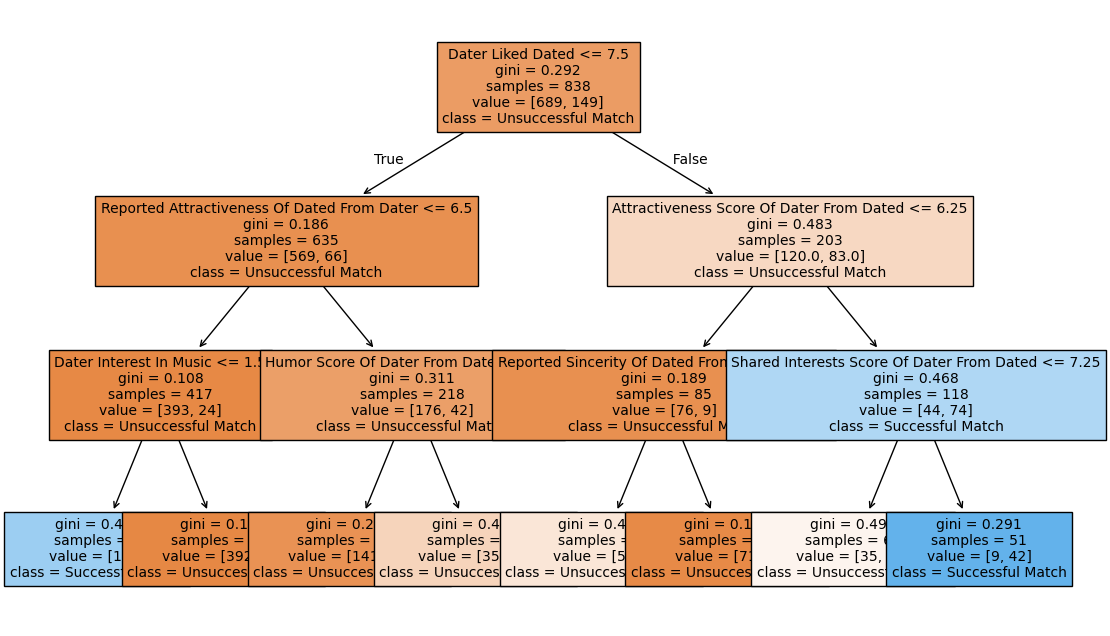

In [48]:
# Visualize the Decision Tree
# Create a figure with specified size
plt.figure(figsize=(13, 8))

# Plot the tree
tree.plot_tree(
    dtree_small,
    class_names=["Unsuccessful Match", "Successful Match"],
    feature_names=list(X_train.columns),
    filled=True,
    fontsize=10
)

# Show the plot
plt.show()

### 3.4. Random Forest

#### 3.4.1. Random Forest with Cross-Validation

In [49]:
# Random Forest without scaling
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Run cross-validation on the training data with the different scoring metrics
# Accuracy
rf_acc_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

# F1-score
rf_f1_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring="f1"
)

# Recall
rf_rec_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring="recall"
)

# Precision
rf_pre_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring="precision"
)

print("Random Forest CV Accuracy scores:", rf_acc_scores)
#print("Random Forest mean Accuracy:", rf_acc_scores.mean())

print("Random Forest CV F1 scores:", rf_f1_scores)
#print("Random Forest mean F1:", rf_f1_scores.mean())

print("Random Forest CV Recall scores:", rf_rec_scores)
#print("Random Forest mean Recall:", rf_rec_scores.mean())

print("Random Forest CV Precision scores:", rf_pre_scores)
#print("Random Forest mean Precision:", rf_pre_scores.mean())

# Build results table
rf_results_before = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "Recall", "Precision"],
    "Mean CV Score for RF": [
        rf_acc_scores.mean(),
        rf_f1_scores.mean(),
        rf_rec_scores.mean(),
        rf_pre_scores.mean()
    ]
})

# Round and sort for readability
rf_results_before = rf_results_before.round(4).sort_values(by="Mean CV Score for RF", ascending=False).reset_index(drop=True)

rf_results_before

Random Forest CV Accuracy scores: [0.85119048 0.86904762 0.85119048 0.85628743 0.8502994 ]
Random Forest CV F1 scores: [0.32432432 0.45       0.3902439  0.5        0.3902439 ]
Random Forest CV Recall scores: [0.2        0.3        0.26666667 0.4137931  0.26666667]
Random Forest CV Precision scores: [0.85714286 0.9        0.72727273 0.63157895 0.72727273]


,Metric,Mean CV Score for RF
0,Accuracy,0.8556
1,Precision,0.7687
2,F1-score,0.4110
3,Recall,0.2894


#### 3.4.2 Random Forest with GridSearchCV


In [50]:
# Hyperparameter grid 
rf_param_grid = {
    "n_estimators": [200, 500],                 
    "max_depth": [None, 5, 10, 20],             
    "min_samples_split": [2, 5, 10],            
    "min_samples_leaf": [1, 2, 4],              
    "max_features": ["sqrt", "log2"],            
    "bootstrap": [True]                         
}

# Evaluate several metrics and choose which one to optimize (refit)
rf_scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision"
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=cv,
    scoring=rf_scoring,
    refit="f1",                
    return_train_score=True,
    n_jobs=-1,
    verbose=3
)

# Fit the GridSearchCV to the training data
rf_grid.fit(X_train, y_train)

# Report best parameters and best score for the refit metric (F1)
print("Best params:", rf_grid.best_params_)
print("Best CV F1 (refit metric):", rf_grid.best_score_)

# Also report best scores for the other metrics for the selected best_index_
rf_best_i = rf_grid.best_index_

# Get the cross-validation results
rf_cvres = rf_grid.cv_results_

# Get the metrics at the best F1 index
rf_acc_after = rf_cvres["mean_test_accuracy"][rf_best_i]
rf_rec_after = rf_cvres["mean_test_recall"][rf_best_i]
rf_f1_after = rf_cvres["mean_test_f1"][rf_best_i]
rf_pre_after = rf_cvres["mean_test_precision"][rf_best_i]

# Create a DataFrame to display the results
rf_results_after = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "F1-score", "Precision"],
    "CV Score for RF (After Tuning)": [
        rf_acc_after,
        rf_rec_after,
        rf_f1_after,
        rf_pre_after
    ]
})

# Round for cleaner display
rf_results_after = rf_results_after.round(4).sort_values(by="CV Score for RF (After Tuning)", ascending=False).reset_index(drop=True)

rf_results_after


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 (refit metric): 0.4345046122856503


,Metric,CV Score for RF (After Tuning)
0,Accuracy,0.8568
1,Precision,0.7439
2,F1-score,0.4345
3,Recall,0.3161


### 3.5. K-Nearest Neighbors

#### 3.5.1. KNN with Cross-Validation

In [51]:
# K-Nearest Neighbors pipeline with scaling
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance",
        p=2
    ))
])

# Run cross-validation on the training data with the different scoring metrics
# Accuracy
knn_acc_scores = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

# F1-score
knn_f1_scores = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="f1"
)

# Recall
knn_rec_scores = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="recall"
)

# precision
knn_pre_scores = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="precision"
)

# Print the cross-validation scores
print("KNN CV Accuracy scores:", knn_acc_scores)
#print("KNN mean Accuracy:", knn_acc_scores.mean())

print("KNN CV F1 scores:", knn_f1_scores)
#print("KNN mean F1:", knn_f1_scores.mean())

print("KNN CV Recall scores:", knn_rec_scores)
#print("KNN mean Recall:", knn_rec_scores.mean())

print("KNN CV Precision scores:", knn_pre_scores)
#print("KNN mean Precision:", knn_pre_scores.mean())

# Build results table
knn_results_before = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "Recall", "Precision"],
    "Mean CV Score for KNN": [
        knn_acc_scores.mean(),
        knn_f1_scores.mean(),
        knn_rec_scores.mean(),
        knn_pre_scores.mean()
    ]
})

# Round and sort for readability
knn_results_before = knn_results_before.round(4).sort_values(by="Mean CV Score for KNN", ascending=False).reset_index(drop=True)

knn_results_before

KNN CV Accuracy scores: [0.83333333 0.85119048 0.83928571 0.84431138 0.8502994 ]
KNN CV F1 scores: [0.125      0.32432432 0.27027027 0.27777778 0.32432432]
KNN CV Recall scores: [0.06666667 0.2        0.16666667 0.17241379 0.2       ]
KNN CV Precision scores: [1.         0.85714286 0.71428571 0.71428571 0.85714286]


,Metric,Mean CV Score for KNN
0,Accuracy,0.8437
1,Precision,0.8286
2,F1-score,0.2643
3,Recall,0.1611


#### 3.5.2 KNN with GridSearchCV


In [52]:
# Hyperparameter grid
knn_param_grid = {
    "scaler": [StandardScaler(), RobustScaler(), "passthrough"],
    "knn__n_neighbors": [1,2,3, 6, 9, 12, 15, 19, 24, 48, 96],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

# Evaluate several metrics and choose which one to optimize (refit)
knn_scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision"
}

# GridSearch
knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=cv,
    scoring=knn_scoring,
    refit="f1",                
    return_train_score=True,
    n_jobs=-1,
    verbose=3
)

# Fit the GridSearchCV to the training data
knn_grid.fit(X_train, y_train)

# Report best parameters and best score for the refit metric (F1)
print("Best params:", knn_grid.best_params_)
print("Best CV F1 (refit metric):", knn_grid.best_score_)

# Also report best scores for the other metrics for the selected best_index_
knn_best_i = knn_grid.best_index_

# Get the cross-validation results
knn_cvres = knn_grid.cv_results_

# Get the metrics at the best F1 index
knn_acc_after = knn_cvres["mean_test_accuracy"][knn_best_i]
knn_rec_after = knn_cvres["mean_test_recall"][knn_best_i]
knn_f1_after = knn_cvres["mean_test_f1"][knn_best_i]
knn_pre_after = knn_cvres["mean_test_precision"][knn_best_i]

# Create a DataFrame to display the results
knn_results_after = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "F1-score", "Precision"],
    "CV Score for KNN (After Tuning)": [
        knn_acc_after,
        knn_rec_after,
        knn_f1_after,
        knn_pre_after
    ]
})

# Round for cleaner display
knn_results_after = knn_results_after.round(4).sort_values(by="CV Score for KNN (After Tuning)", ascending=False).reset_index(drop=True)

Fitting 5 folds for each of 132 candidates, totalling 660 fits
Best params: {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform', 'scaler': StandardScaler()}
Best CV F1 (refit metric): 0.3772222671373775


### 4. Results and Evaluation

#### 4.1. Results From the Models

##### 4.1.1. F1 Score Comparison for all Models

In [53]:
# Compile results into a DataFrame for comparison
results = {
    "Model": ["DummyClassifier", "Logistic Regression", "Decision Tree", "Random Forest", "KNN"],
    "F1 Score": [
        round(f1_dummy, 4),
        round(lr_grid.best_score_, 4),
        round(dt_grid.best_score_, 4),
        round(rf_grid.best_score_, 4),
        round(knn_grid.best_score_, 4)
    ]
}

# Create DataFrame
results_df_f1 = pd.DataFrame(results)

# Sort by F1 score (highest first) + reset index cleanly
results_df_f1 = results_df_f1.sort_values("F1 Score", ascending=False).reset_index(drop=True)

# Display the results
results_df_f1

,Model,F1 Score
0,Logistic Regression,0.5517
1,Decision Tree,0.4851
2,Random Forest,0.4345
3,KNN,0.3772
4,DummyClassifier,0.0000


##### 4.1.2. Tables for all Models with different Scoring Metrics

In [54]:
def get_best_scores(grid):
    """Return accuracy, recall, f1, precision at the best F1 model."""
    i = grid.best_index_
    cvres = grid.cv_results_
    return (
        cvres["mean_test_f1"][i],
        cvres["mean_test_recall"][i],
        cvres["mean_test_accuracy"][i],
        cvres["mean_test_precision"][i],
    )

# After tuning (F1, Recall, Accuracy, Precision) for each model
lr_f1_after,  lr_rec_after,  lr_acc_after,  lr_prec_after  = get_best_scores(lr_grid)
dt_f1_after,  dt_rec_after,  dt_acc_after,  dt_prec_after  = get_best_scores(dt_grid)
rf_f1_after,  rf_rec_after,  rf_acc_after,  rf_prec_after  = get_best_scores(rf_grid)
knn_f1_after, knn_rec_after, knn_acc_after, knn_prec_after = get_best_scores(knn_grid)


In [55]:
# Logistic Regression (before tuning)
lr_acc_before    = lr_acc_scores.mean()
lr_f1_before     = lr_f1_scores.mean()
lr_rec_before    = lr_rec_scores.mean()
lr_pre_before   = lr_pre_scores.mean()

# Decision Tree
dt_acc_before    = dt_acc_scores.mean()
dt_f1_before     = dt_f1_scores.mean()
dt_rec_before    = dt_rec_scores.mean()
dt_pre_before   = dt_pre_scores.mean()

# Random Forest
rf_acc_before    = rf_acc_scores.mean()
rf_f1_before     = rf_f1_scores.mean()
rf_rec_before    = rf_rec_scores.mean()
rf_pre_before   = rf_pre_scores.mean()

# KNN
knn_acc_before   = knn_acc_scores.mean()
knn_f1_before    = knn_f1_scores.mean()
knn_rec_before   = knn_rec_scores.mean()
knn_pre_before  = knn_pre_scores.mean()

# Baseline / Dummy – no tuning, so “after” = “before”
bl_f1_before     = f1_dummy
bl_rec_before    = rec_dummy
bl_acc_before    = acc_dummy
bl_pre_before   = pre_dummy

bl_f1_after      = bl_f1_before
bl_rec_after     = bl_rec_before
bl_acc_after     = bl_acc_before
bl_pre_after    = bl_pre_before


In [56]:

index = [
    "F1 before tuning",
    "F1 after tuning",
    "Recall before tuning",
    "Recall after tuning",
    "Accuracy before tuning",
    "Accuracy after tuning",
    "Precision before tuning",
    "Precision after tuning",
]

results_all = pd.DataFrame(
    {
        "BL": [
            bl_f1_before,  bl_f1_after,
            bl_rec_before, bl_rec_after,
            bl_acc_before, bl_acc_after,
            bl_pre_before, bl_pre_after,
        ],
        "LR": [
            lr_f1_before,  lr_f1_after,
            lr_rec_before, lr_rec_after,
            lr_acc_before, lr_acc_after,
            lr_pre_before, lr_pre_after,
        ],
        "DC": [
            dt_f1_before,  dt_f1_after,
            dt_rec_before, dt_rec_after,
            dt_acc_before, dt_acc_after,
            dt_pre_before, dt_pre_after,
        ],
        "RF": [
            rf_f1_before,  rf_f1_after,
            rf_rec_before, rf_rec_after,
            rf_acc_before, rf_acc_after,
            rf_pre_before, rf_pre_after,
        ],
        "KNN": [
            knn_f1_before, knn_f1_after,
            knn_rec_before, knn_rec_after,
            knn_acc_before, knn_acc_after,
            knn_pre_before, knn_pre_after,
        ],
    },
    index=index,
)

# Optional: round for nicer display
results_all = results_all.round(4)

results_all

,BL,LR,DC,RF,KNN
F1 before tuning,0.0000,0.5215,0.4634,0.4110,0.2643
F1 after tuning,0.0000,0.5517,0.4851,0.4345,0.3772
Recall before tuning,0.0000,0.4630,0.4763,0.2894,0.1611
Recall after tuning,0.0000,0.7582,0.4163,0.3161,0.3754
Accuracy before tuning,0.8238,0.8509,0.8030,0.8556,0.8437
Accuracy after tuning,0.8238,0.7792,0.8413,0.8568,0.7792
Precision before tuning,0.0000,0.6100,0.4540,0.7687,0.8286
Precision after tuning,0.0000,0.4370,0.5850,0.7439,0.3854


### 4. Test Performance

4.1 Logistical regression

In [57]:
lr_best = lr_grid.best_estimator_

# 2) Predict on test set
y_pred_test_lr = lr_best.predict(X_test)
y_proba_test_lr = lr_best.predict_proba(X_test)[:, 1]   # P(class=1)

# 3) Confusion matrix -> TN, FP, FN, TP
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(
    y_test, y_pred_test_lr, labels=[0, 1]
).ravel()

# 4) Classification KPIs (test)
lr_test_acc = accuracy_score(y_test, y_pred_test_lr)
lr_test_prec = precision_score(y_test, y_pred_test_lr, zero_division=0)
lr_test_rec = recall_score(y_test, y_pred_test_lr, zero_division=0)
lr_test_f1 = f1_score(y_test, y_pred_test_lr, zero_division=0)

# Probability-based metrics
lr_test_roc_auc = roc_auc_score(y_test, y_proba_test_lr)
lr_test_logloss = log_loss(y_test, y_proba_test_lr, labels=[0, 1])   # cross-entropy
lr_test_brier = brier_score_loss(y_test, y_proba_test_lr)

# 5) One-row results table
lr_test_results = pd.DataFrame([{
    "Model": "Logistic Regression (tuned)",

    "Test_Accuracy": lr_test_acc,
    "Test_Precision": lr_test_prec,
    "Test_Recall": lr_test_rec,
    "Test_F1": lr_test_f1,

    "Test_ROC_AUC": lr_test_roc_auc,
    "Test_LogLoss": lr_test_logloss,
    "Test_Brier": lr_test_brier,

    "TP": tp_lr, "FP": fp_lr, "TN": tn_lr, "FN": fn_lr
}]).set_index("Model")

display(lr_test_results.round(4))

,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_LogLoss,Test_Brier,TP,FP,TN,FN
Model,,,,,,,,,,,
Logistic Regression (tuned),0.7238,0.3562,0.7027,0.4727,0.7916,0.5268,0.177,26,47,126,11


4.2 Decision tree

In [58]:
dt_best = dt_grid.best_estimator_

y_pred_test_dt = dt_best.predict(X_test)

# DecisionTreeClassifier supports predict_proba
y_proba_test_dt = dt_best.predict_proba(X_test)[:, 1]

# 3) Confusion matrix -> TN, FP, FN, TP
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(
    y_test, y_pred_test_dt, labels=[0, 1]
).ravel()

# 4) Classification KPIs (test)
dt_test_acc = accuracy_score(y_test, y_pred_test_dt)
dt_test_prec = precision_score(y_test, y_pred_test_dt, zero_division=0)
dt_test_rec = recall_score(y_test, y_pred_test_dt, zero_division=0)
dt_test_f1 = f1_score(y_test, y_pred_test_dt, zero_division=0)

# Probability-based metrics
dt_test_roc_auc = roc_auc_score(y_test, y_proba_test_dt)
dt_test_logloss = log_loss(y_test, y_proba_test_dt, labels=[0, 1])   # cross-entropy
dt_test_brier = brier_score_loss(y_test, y_proba_test_dt)

# 5) One-row results table
dt_test_results = pd.DataFrame([{
    "Model": "Decision Tree",

    "Test_Accuracy": dt_test_acc,
    "Test_Precision": dt_test_prec,
    "Test_Recall": dt_test_rec,
    "Test_F1": dt_test_f1,

    "Test_ROC_AUC": dt_test_roc_auc,
    "Test_LogLoss": dt_test_logloss,
    "Test_Brier": dt_test_brier,

    "TP": tp_dt, "FP": fp_dt, "TN": tn_dt, "FN": fn_dt
}]).set_index("Model")

display(dt_test_results.round(4))

,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_LogLoss,Test_Brier,TP,FP,TN,FN
Model,,,,,,,,,,,
Decision Tree,0.781,0.3448,0.2703,0.303,0.6933,1.7025,0.1864,10,19,154,27


4.3 Random forest

In [59]:
rf_best = rf_grid.best_estimator_

# 2) Predict on test set
y_pred_test_rf = rf_best.predict(X_test)
y_proba_test_rf = rf_best.predict_proba(X_test)[:, 1]   # P(class=1)

# 3) Confusion matrix -> TN, FP, FN, TP
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(
    y_test, y_pred_test_rf, labels=[0, 1]
).ravel()

# 4) Classification KPIs (test)
rf_test_acc = accuracy_score(y_test, y_pred_test_rf)
rf_test_prec = precision_score(y_test, y_pred_test_rf, zero_division=0)
rf_test_rec = recall_score(y_test, y_pred_test_rf, zero_division=0)
rf_test_f1 = f1_score(y_test, y_pred_test_rf, zero_division=0)

# Probability-based metrics
rf_test_roc_auc = roc_auc_score(y_test, y_proba_test_rf)
rf_test_logloss = log_loss(y_test, y_proba_test_rf, labels=[0, 1])   # cross-entropy
rf_test_brier = brier_score_loss(y_test, y_proba_test_rf)

# 5) One-row results table
rf_test_results = pd.DataFrame([{
    "Model": "Random Forest (tuned)",

    "Test_Accuracy": rf_test_acc,
    "Test_Precision": rf_test_prec,
    "Test_Recall": rf_test_rec,
    "Test_F1": rf_test_f1,

    "Test_ROC_AUC": rf_test_roc_auc,
    "Test_LogLoss": rf_test_logloss,
    "Test_Brier": rf_test_brier,

    "TP": tp_rf, "FP": fp_rf, "TN": tn_rf, "FN": fn_rf
}]).set_index("Model")

display(rf_test_results.round(4))


,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_LogLoss,Test_Brier,TP,FP,TN,FN
Model,,,,,,,,,,,
Random Forest (tuned),0.8429,0.7,0.1892,0.2979,0.8406,0.3506,0.1093,7,3,170,30


4.4 KNN

In [60]:
knn_best = knn_grid.best_estimator_

# 2) Predict on test set
y_pred_test = knn_best.predict(X_test)
y_proba_test = knn_best.predict_proba(X_test)[:, 1]   # P(class=1)

# 3) Confusion matrix -> TN, FP, FN, TP
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test, labels=[0, 1]).ravel()

# 4) Test KPIs
knn_test_acc = accuracy_score(y_test, y_pred_test)
knn_test_prec = precision_score(y_test, y_pred_test, zero_division=0)
knn_test_rec = recall_score(y_test, y_pred_test, zero_division=0)
knn_test_f1 = f1_score(y_test, y_pred_test, zero_division=0)

knn_test_roc_auc = roc_auc_score(y_test, y_proba_test)
knn_test_logloss = log_loss(y_test, y_proba_test, labels=[0, 1])     # cross-entropy
knn_test_brier = brier_score_loss(y_test, y_proba_test)


# 5) One-row test results table (good for later model comparison)
knn_test_results = pd.DataFrame([{
    "Model": "KNN tuned",
    "Test_Accuracy": knn_test_acc,
    "Test_Precision": knn_test_prec,
    "Test_Recall": knn_test_rec,
    "Test_F1": knn_test_f1,
    "Test_ROC_AUC": knn_test_roc_auc,
    "Test_LogLoss": knn_test_logloss,
    "Test_Brier": knn_test_brier,
    "TP": tp, "FP": fp, "TN": tn, "FN": fn
}]).set_index("Model")

display(knn_test_results.round(4))


,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_LogLoss,Test_Brier,TP,FP,TN,FN
Model,,,,,,,,,,,
KNN tuned,0.7952,0.4062,0.3514,0.3768,0.6208,7.3804,0.2048,13,19,154,24


4.5 result table 

In [61]:
final_test_results = pd.concat([
    lr_test_results,
    dt_test_results,
    rf_test_results,    
    knn_test_results

])


final_test_results1 = final_test_results[[
    "Test_Accuracy",
    "Test_Precision",
    "Test_Recall",
    "Test_F1"
  
]]


final_test_results2 = final_test_results[[
    "Test_ROC_AUC",
    "Test_LogLoss",
    "Test_Brier"
]]
final_test_results3 = final_test_results[[
  "TP", "FP", "TN", "FN"
]]


display(final_test_results1.round(4))
display(final_test_results2.round(4))
display(final_test_results3.round(4))

,Test_Accuracy,Test_Precision,Test_Recall,Test_F1
Model,,,,
Logistic Regression (tuned),0.7238,0.3562,0.7027,0.4727
Decision Tree,0.7810,0.3448,0.2703,0.3030
Random Forest (tuned),0.8429,0.7000,0.1892,0.2979
KNN tuned,0.7952,0.4062,0.3514,0.3768


,Test_ROC_AUC,Test_LogLoss,Test_Brier
Model,,,
Logistic Regression (tuned),0.7916,0.5268,0.1770
Decision Tree,0.6933,1.7025,0.1864
Random Forest (tuned),0.8406,0.3506,0.1093
KNN tuned,0.6208,7.3804,0.2048


,TP,FP,TN,FN
Model,,,,
Logistic Regression (tuned),26,47,126,11
Decision Tree,10,19,154,27
Random Forest (tuned),7,3,170,30
KNN tuned,13,19,154,24
